In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.models import Model
from keras.layers import (Input, Activation, Reshape, Conv2D, Lambda, Add)
import tensorflow as tf
import tensorflow as tf

from tensorflow import keras
from tqdm import tqdm
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import skimage.filters
from skimage.util import random_noise 
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral

# https://www.azavea.com/blog/2017/05/30/deep-learning-on-aerial-imagery/

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
TRAIN_PATH = 'archive/segmentation/train/'
TEST_PATH = 'archive/segmentation/test/'

seed = 42
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:

# print('Resizing training images and masks')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent = {}

#train images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    correspondent[n] = str(id_)

# #train masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask_

# # test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent_test = {}

size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    correspondent_test[n] = str(id_)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask_
print('Done!')

In [ ]:
model1 = tf.keras.models.load_model('model_FCN_ResNet50.h5')

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model1.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model1.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model1.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


## Primele 20 cele mai bune segmentari

In [ ]:
v = []
for k in range(len(preds_test_t)):
    gtMask = Y_test[k]
    predMask = preds_test_t[k]
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(len(gtMask)):
        for j in range(len(gtMask[i])):
            if gtMask[i][j] == True and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == False and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == True and predMask[i][j] == 0:
                fn += 1
            elif gtMask[i][j] == False and predMask[i][j] == 0:
                tn += 1
    iou = tp / (tp + fp + fn)
    v.append(round(iou*100, 3))

In [ ]:
number1 = correspondent_test
print(number1)

In [ ]:
print(v)
print(number1)

In [ ]:
def bubbleSort(v,number):
    n = len(v)
    for i in range(n-1):
        for j in range(0, n-i-1):
            if v[j] < v[j+1]:
                swapped = True
                number[j+1], number[j] = number[j], number[j+1]
                v[j+1], v[j] = v[j], v[j+1]

bubbleSort(v,number)

# print("Sorted array is:")
# for i in range(len(v)):
#     print("% d" % v[i], end=" ")
                    
print(v)
print(number)

In [ ]:
correspondent1 = list(number.items())
iou2 = v[:20]
items = correspondent1[:20]
for i in items:
    print(i[1])
print(iou2)

## Se plaseaza imaginile

In [5]:
imagini_path = 'archive/segmentation/imagini/'
test_ids = next(os.walk(imagini_path))[1]
# # test images
X_test1 = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test1 = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent_test = {}

size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = imagini_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test1[n] = img
    correspondent_test[n] = str(id_)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test1[n] = mask_
print('Done!')

Resizing test images


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 43.50it/s]

Done!


In [8]:
preds_test = model1.predict(X_test1, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 1s/step


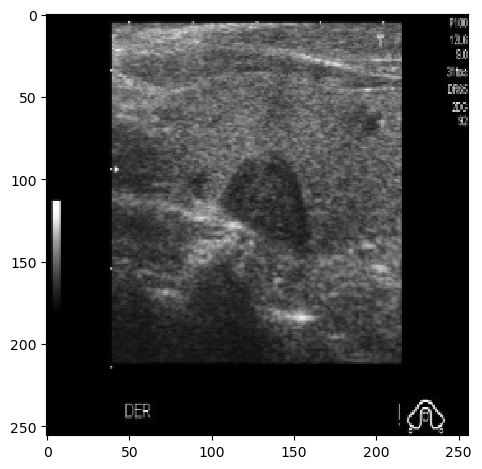

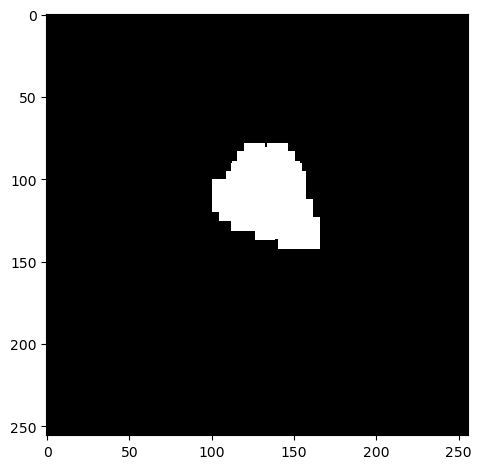

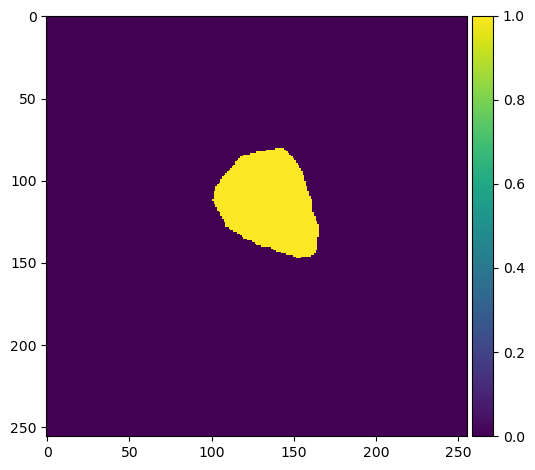

Image number:  363_1


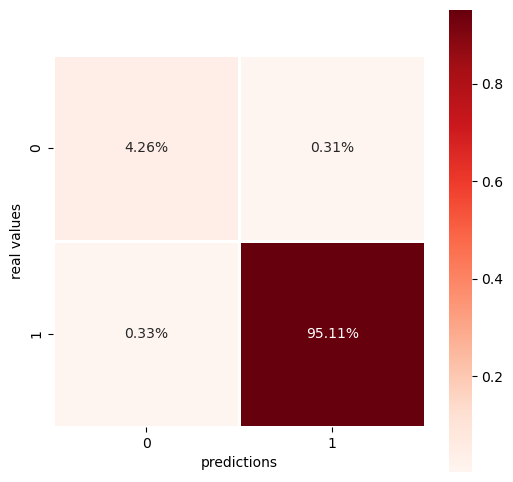

True positive:  2790
False positive:  214
False negative:  200
True negative:  62332
MCC:  92.762 %
F1:  93.093 %
Acc:  99.368 %
IoU:  87.079 %


In [11]:
x = random.randint(0, len(preds_test_t))
x = 0
# Se afiseaza imaginea impreuna cu masca si predictia
imshow(X_test1[x])
plt.show()
imshow(np.squeeze(Y_test1[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()

print("Image number: ", correspondent_test[x])

gtMask = Y_test1[x]
predMask = preds_test_t[x]   

# Get the parameters value 
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(gtMask)):
    for j in range(len(gtMask[i])):
        if gtMask[i][j] == True and predMask[i][j] == 1:
            tp += 1
        elif gtMask[i][j] == False and predMask[i][j] == 1:
            fp += 1
        elif gtMask[i][j] == True and predMask[i][j] == 0:
            fn += 1
        elif gtMask[i][j] == False and predMask[i][j] == 0:
            tn += 1
    
# Show the Confusion Matrix          
cmat = [[tp, fn], [fp, tn]]
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()

# Print parameters
print("True positive: ",tp)
print("False positive: ",fp)
print("False negative: ",fn)
print("True negative: ",tn)

# Calculate the evaluation metrics
iou = tp / (tp + fp + fn)
total = tp + fp + fn + tn
accuracy = (tp + tn) / total
f1_score = (2 * tp) / ((2 * tp) + fp + fn)
mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

# Print the evaluation metrics
print("MCC: ", round(mcc*100, 3), "%")
print("F1: ", round(f1_score*100, 3), "%")
print("Acc: ", round(accuracy*100, 3), "%")    
print("IoU: ", round(iou*100, 3), "%")

In [12]:
correspondent_test

{0: '363_1',
 1: '473_1',
 2: '418_1',
 3: '333_1',
 4: '339_1',
 5: '469_1',
 6: '377_1',
 7: '406_1',
 8: '379_1',
 9: '356_1',
 10: '448_1',
 11: '360_1',
 12: '424_1',
 13: '475_1',
 14: '321_1',
 15: '400_1',
 16: '337_2',
 17: '465_1',
 18: '485_1',
 19: '395_1'}

In [18]:
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = imagini_path + id_
    os.mkdir(path + "/results")

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 5107.22it/s]


In [63]:
px = 1/plt.rcParams['figure.dpi']
for x in range(len(correspondent_test)):
    imshow(np.squeeze(preds_test_t[x]))
    plt.figure(figsize=(500*px,300*px))
    plt.show()

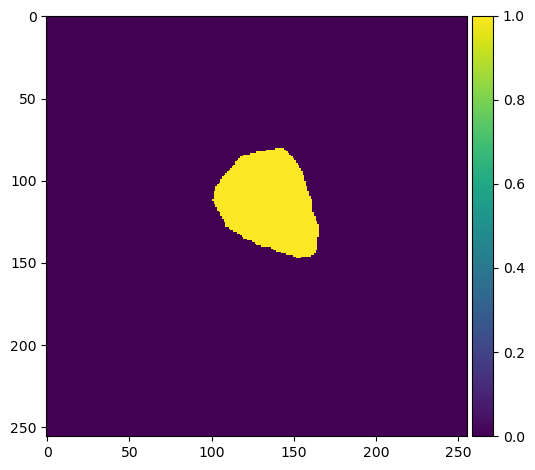

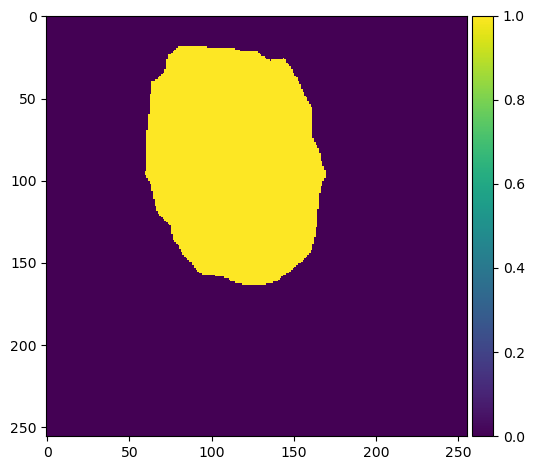

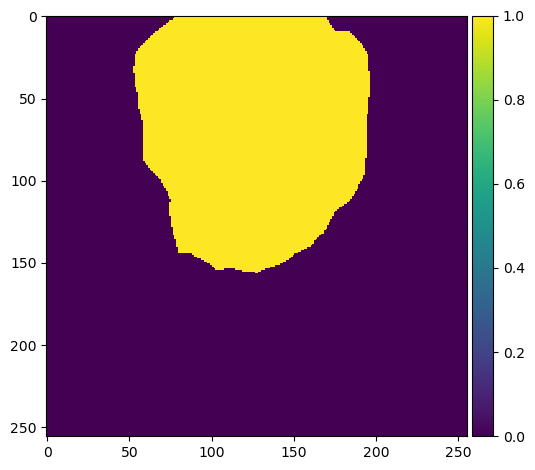

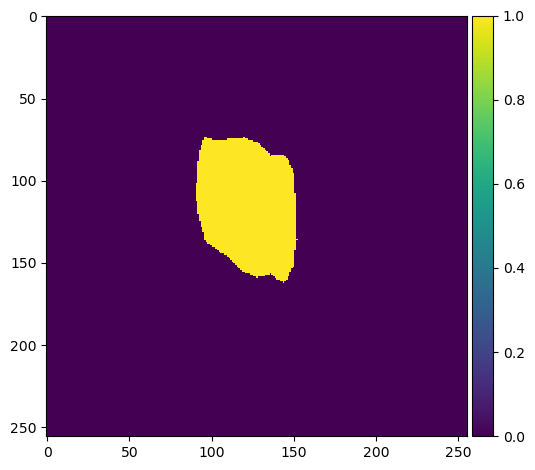

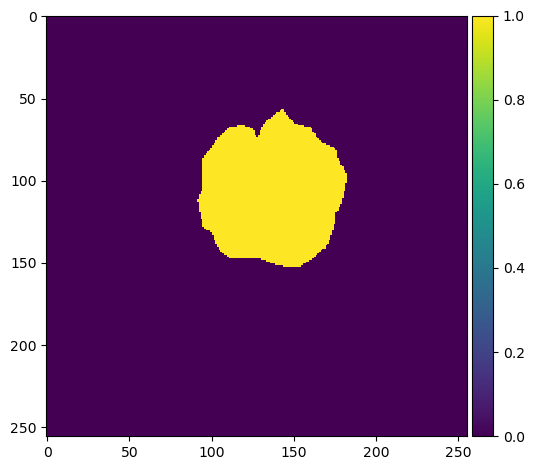

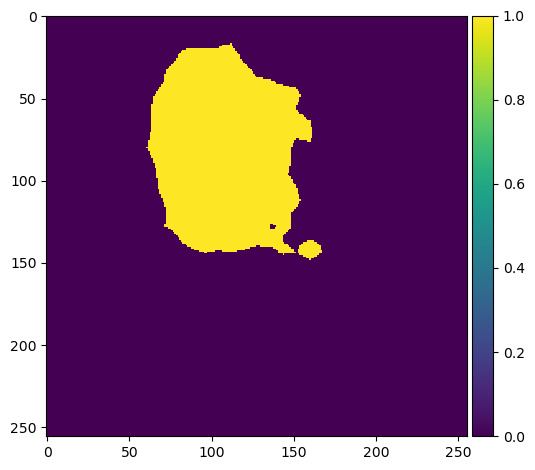

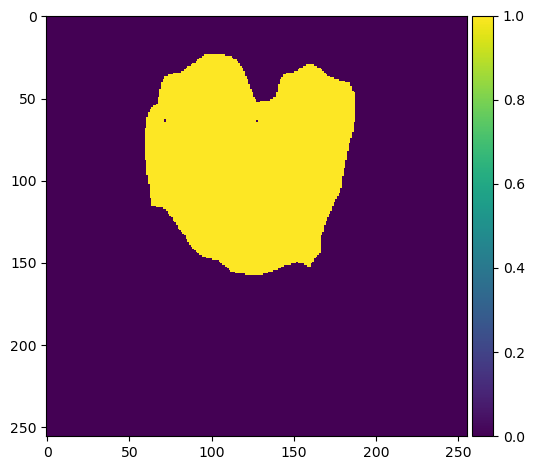

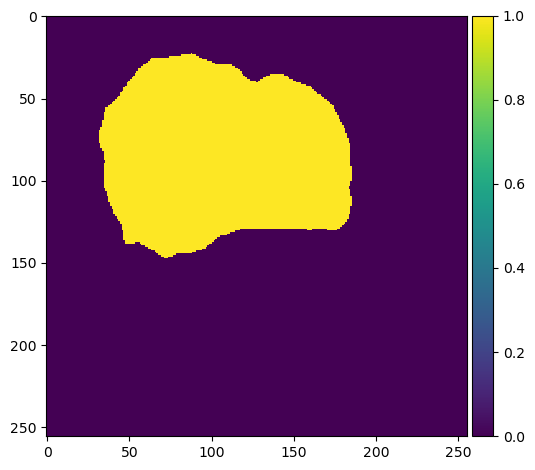

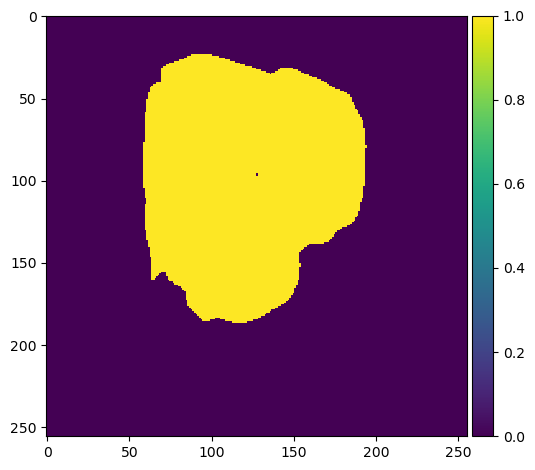

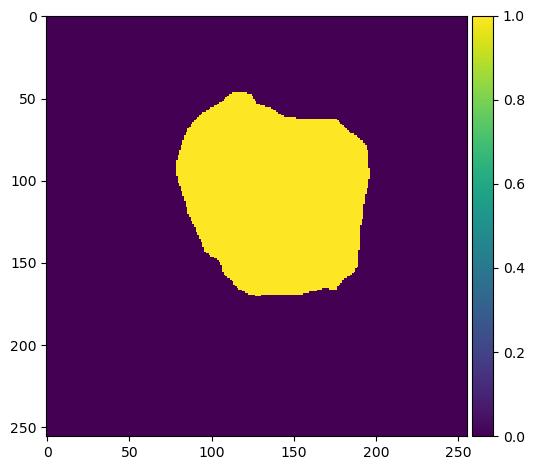

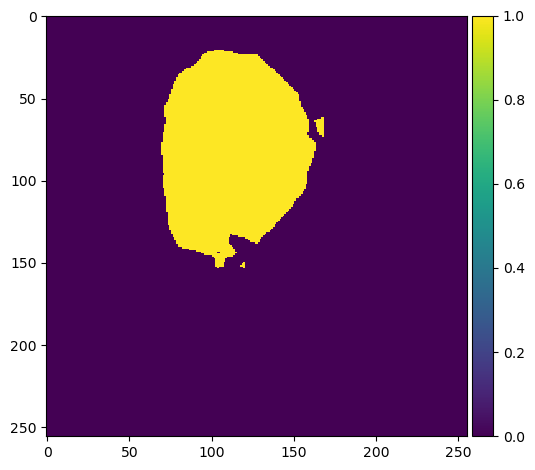

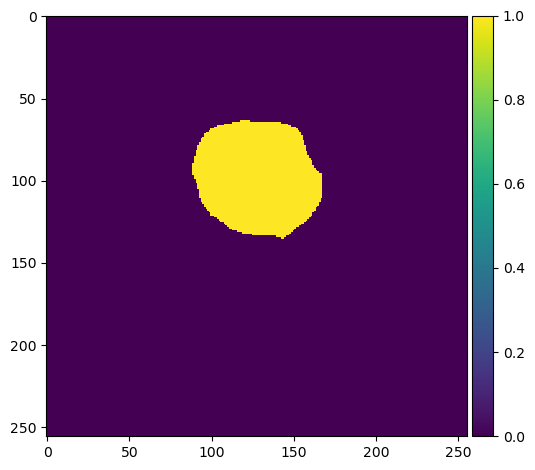

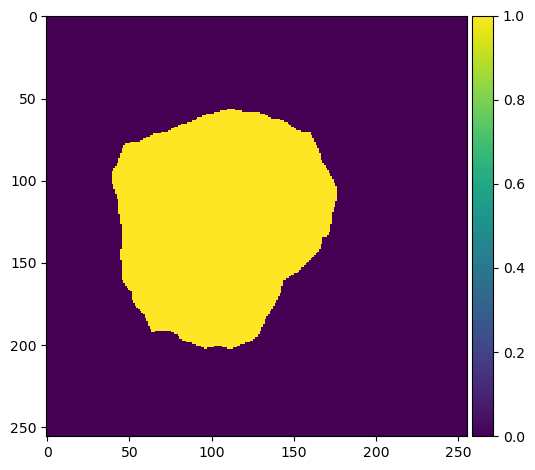

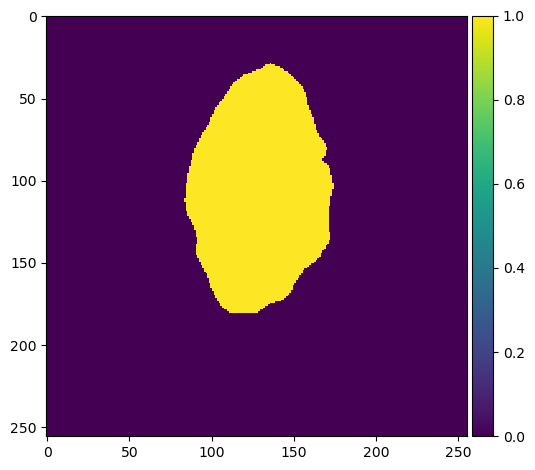

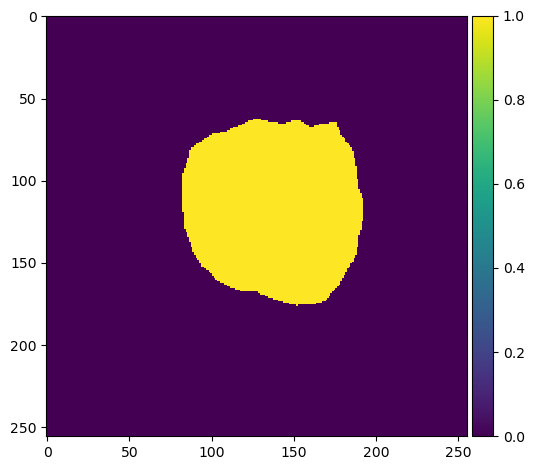

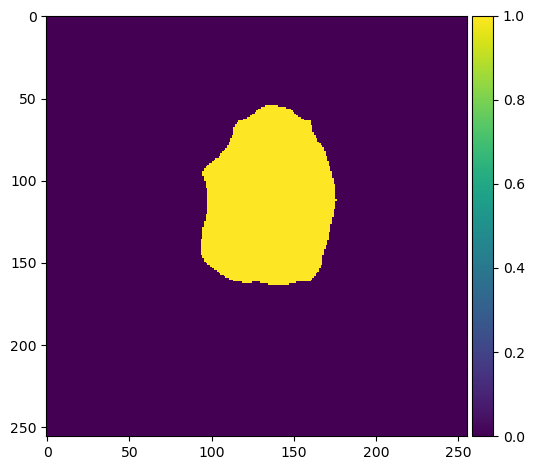

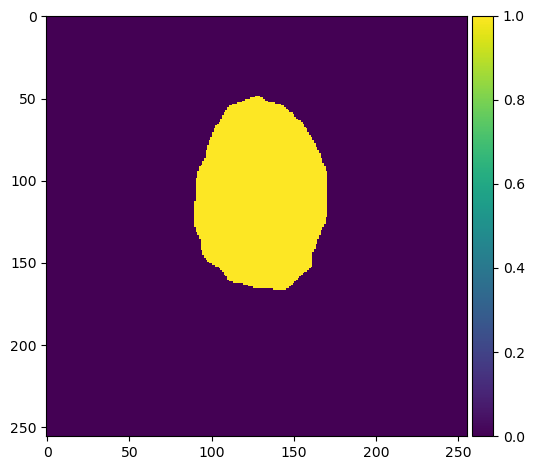

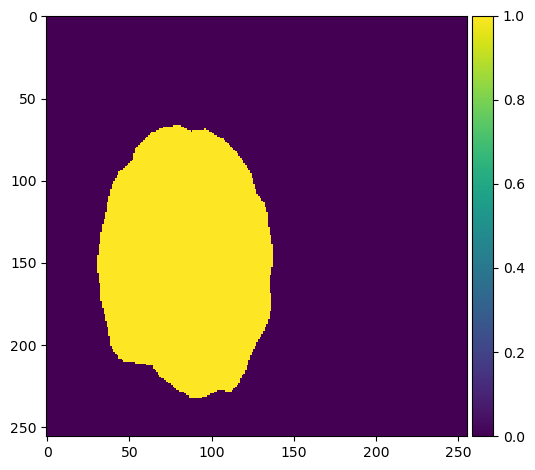

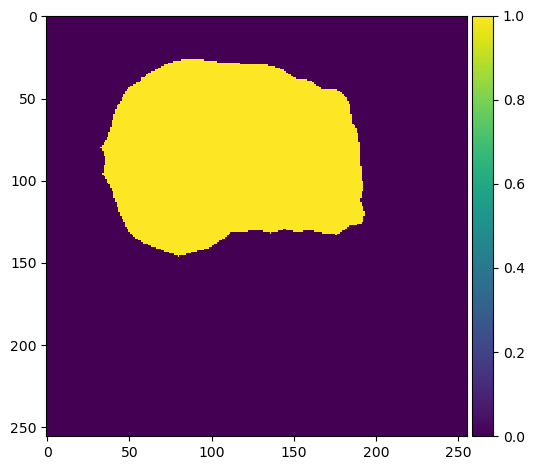

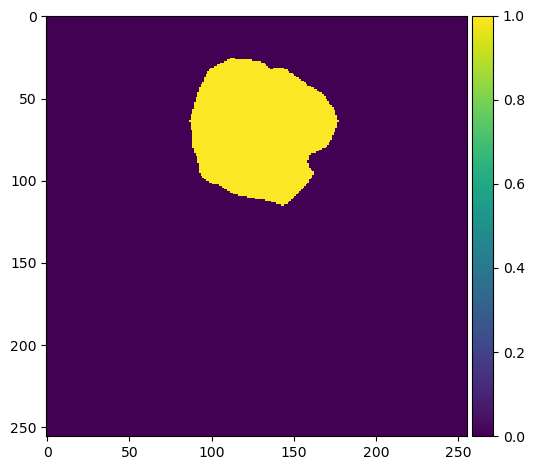

In [87]:
for x in range(len(correspondent_test)):
    path = imagini_path + correspondent_test[x] + '/results/'
#     print(path)
    imshow(np.squeeze(preds_test_t[x]))
    plt.savefig(path + correspondent_test[x] + '.png', dpi= 72, bbox_inches='tight')
    plt.show()
    

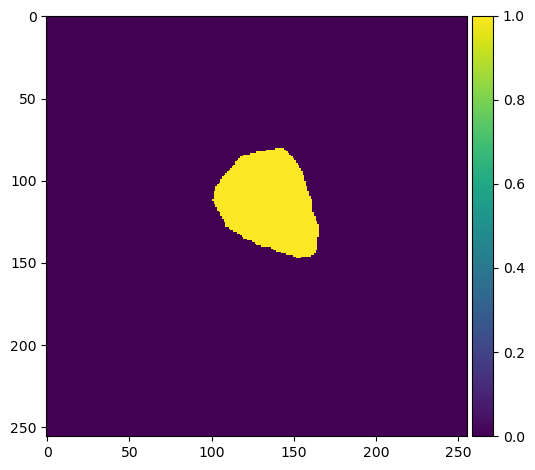

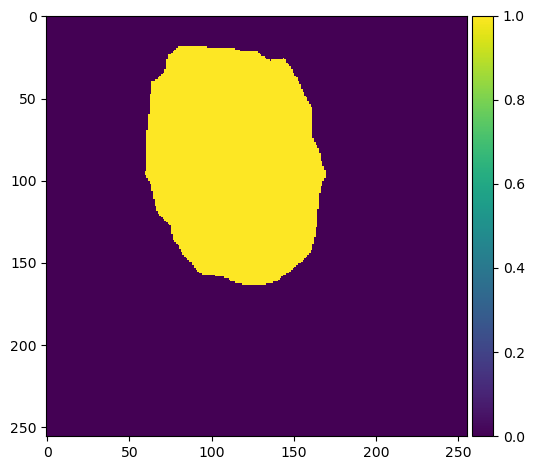

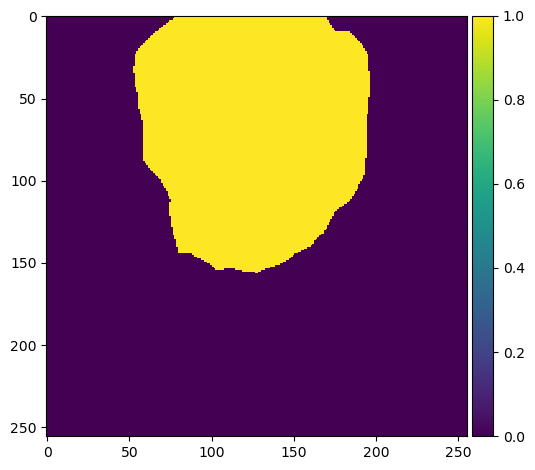

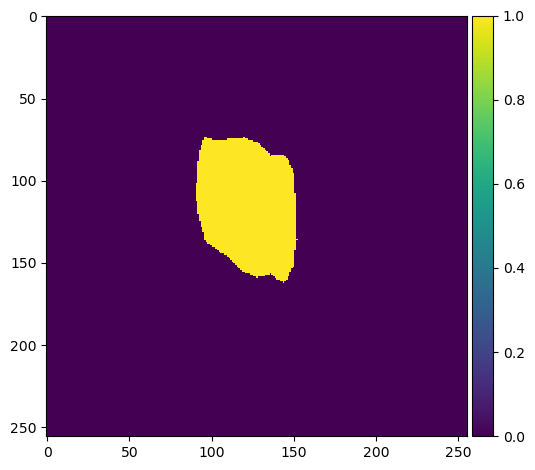

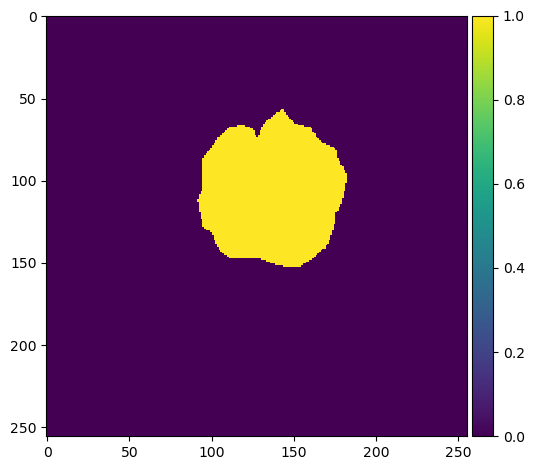

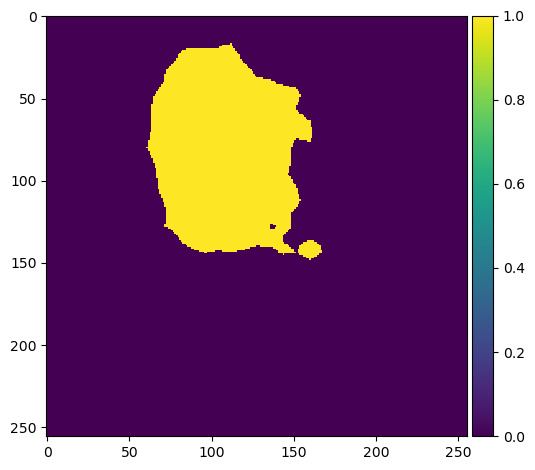

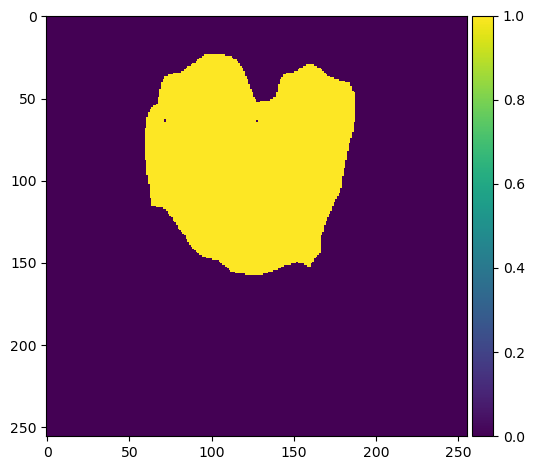

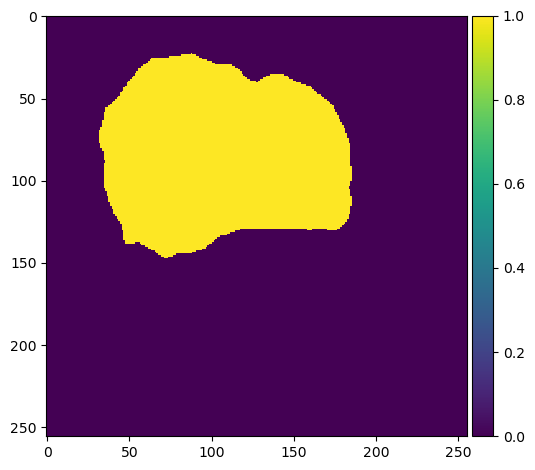

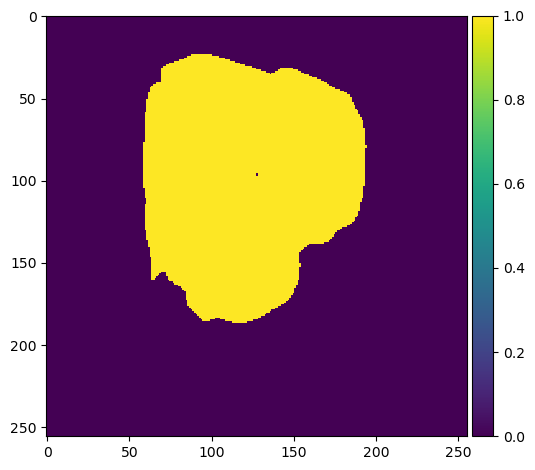

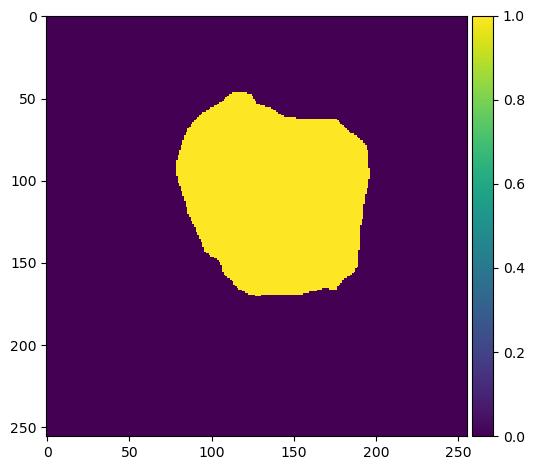

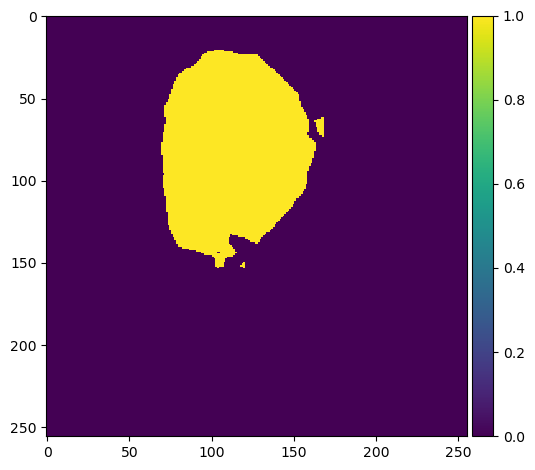

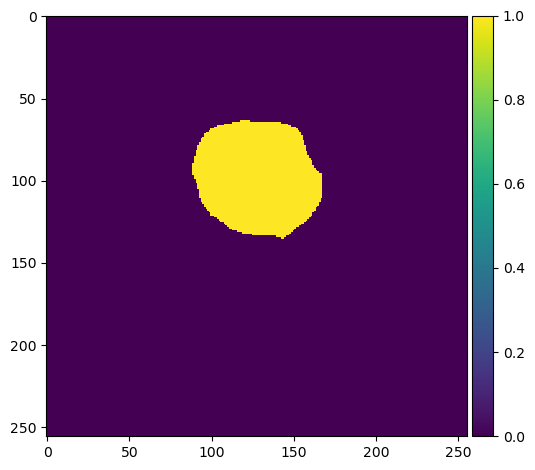

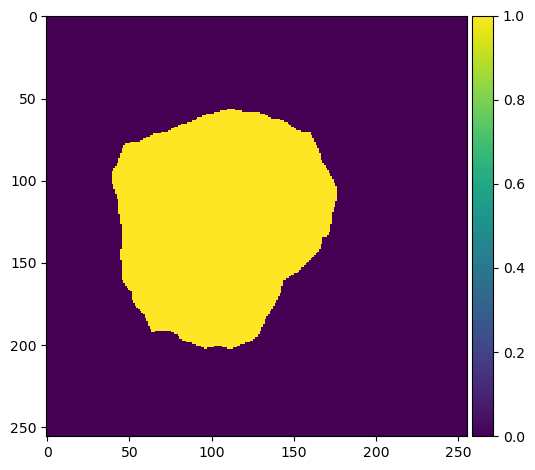

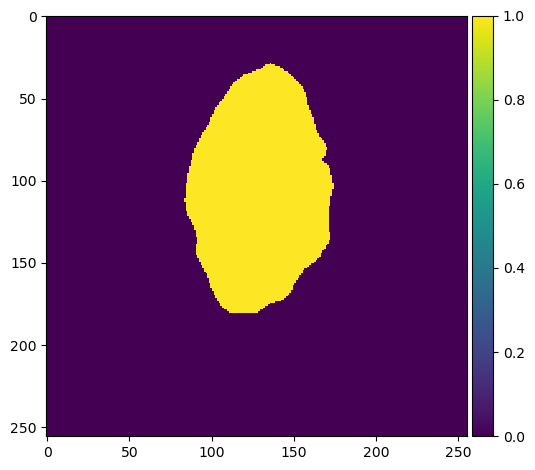

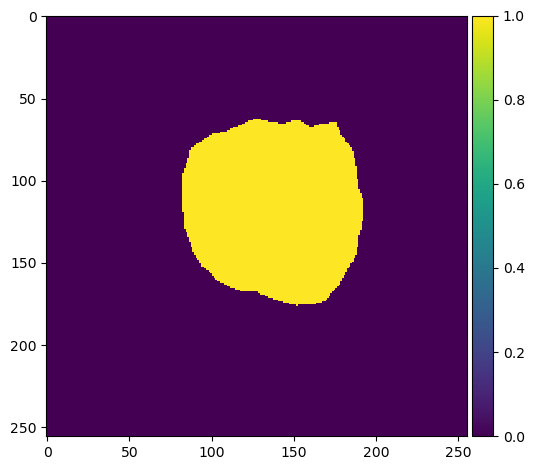

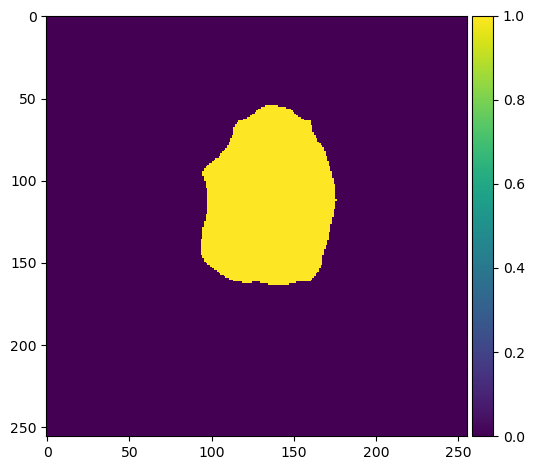

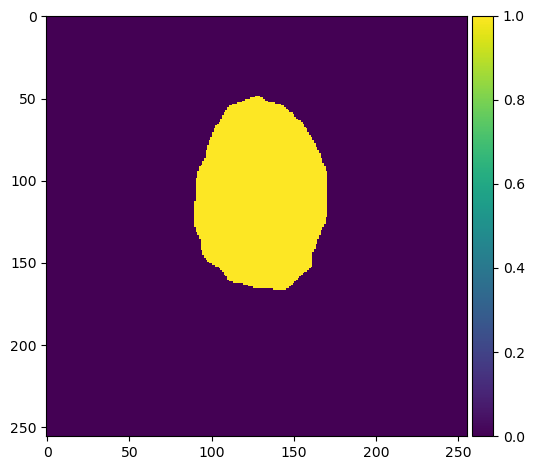

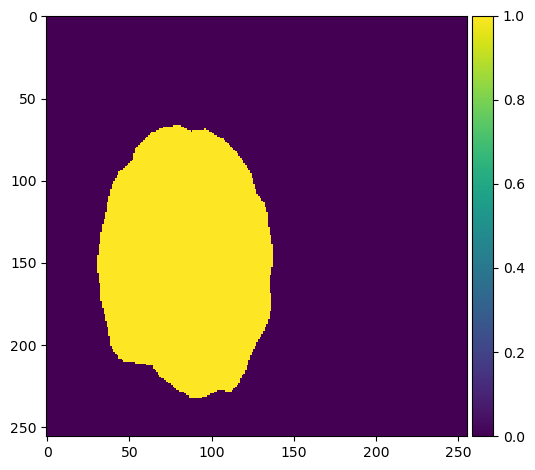

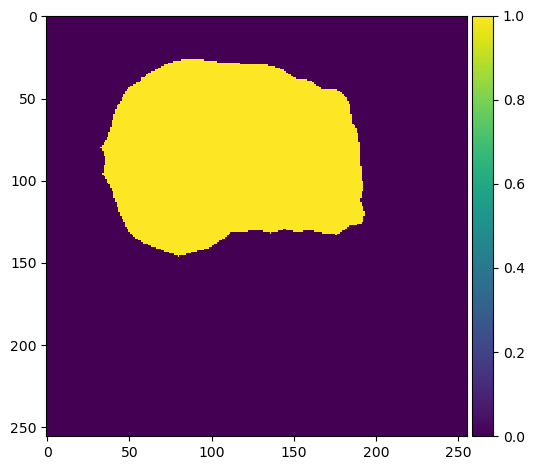

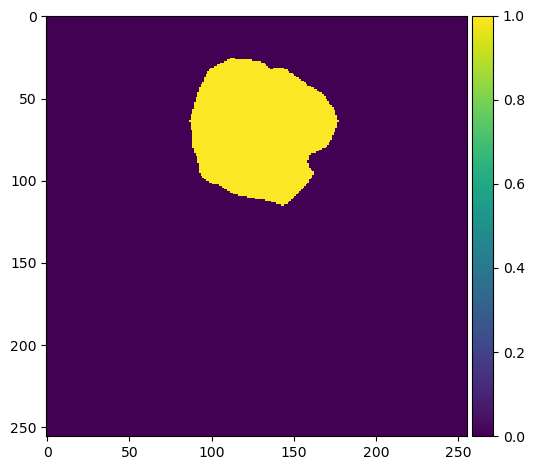

In [27]:
for x in range(len(correspondent_test)):
    imshow(np.squeeze(preds_test_t[x]))
    plt.show()

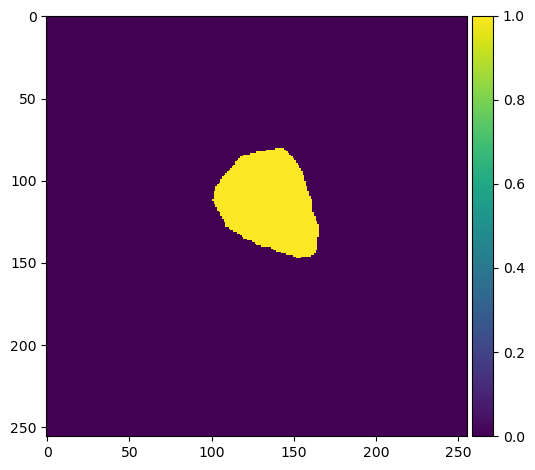

In [84]:
x=0
path = imagini_path + correspondent_test[x] + '/results/'
#     print(path)
imshow(np.squeeze(preds_test_t[x]))
plt.savefig(path + correspondent_test[x] + '.png', dpi= 72, bbox_inches='tight')
plt.show()

In [88]:
from PIL import Image
for x in range(len(correspondent_test)):
# size = 641, 394
    path = imagini_path + correspondent_test[x] + '/results/' + correspondent_test[x]+'.png'
    im = Image.open(path)
    im = im.resize((709, 400))
    im.save(imagini_path + correspondent_test[x] + '/results/' + correspondent_test[x]+".png")

